# Import Library 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(context="talk")

from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import nn, optimizers
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.callbacks import Callback, EarlyStopping
from keras.models import Sequential
from keras.losses import categorical_crossentropy
from keras.layers import Embedding, LSTM, Dense, GlobalAveragePooling1D, Bidirectional, Dropout

# Import Dataset

In [2]:
df =(pd.read_csv("/content/Corona_NLP_train.csv", encoding='iso-8859-1').drop(["UserName",  "ScreenName", "Location", "TweetAt"], axis="columns"))
df.columns = ["text", "label"]

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41157 entries, 0 to 41156
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    41157 non-null  object
 1   label   41157 non-null  object
dtypes: object(2)
memory usage: 643.2+ KB


In [4]:
df.head(3)

text     label
0  @MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...   Neutral
1  advice Talk to your neighbours family to excha...  Positive
2  Coronavirus Australia: Woolworths to give elde...  Positive

In [5]:
df["label"].value_counts()

Positive              11422
Negative               9917
Neutral                7713
Extremely Positive     6624
Extremely Negative     5481
Name: label, dtype: int64

# Concat new_df dan df

In [6]:
category = pd.get_dummies(df["label"])

new_df = pd.concat([df, category], axis="columns")
new_df.drop("label", axis="columns", inplace=True)

In [7]:
new_df.head(3)

text  ...  Positive
0  @MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...  ...         0
1  advice Talk to your neighbours family to excha...  ...         1
2  Coronavirus Australia: Woolworths to give elde...  ...         1

[3 rows x 6 columns]

# Datasets Splitting

In [8]:
X = new_df["text"].values
y = new_df[["Extremely Negative", "Extremely Positive", "Negative", "Neutral", "Positive"]].values

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((32925,), (8232,), (32925, 5), (8232, 5))

# Tokenisasi

In [9]:
tokenizer = Tokenizer(num_words=5000, oov_token="x")

In [10]:
tokenizer.fit_on_texts(X_train)
tokenizer.fit_on_texts(X_test)

# Sequences

In [11]:
sequence_train = tokenizer.texts_to_sequences(X_train)
sequence_test = tokenizer.texts_to_sequences(X_test)

# Proses Padding

In [12]:
padded_train = pad_sequences(sequence_train, padding="post")
padded_test = pad_sequences(sequence_test, padding="post")

# Arsitektur Model

In [13]:
model = Sequential([
                    Embedding(input_dim=5001, output_dim=32),
                    Bidirectional(LSTM(64, return_sequences=True)),     
                    GlobalAveragePooling1D(),
                    Dense(128, activation="relu"),
                    Dropout(0.4),
                    Dense(128, activation="relu"),
                    Dense(64, activation="relu"),
                    Dense(5, activation="softmax")
])

# Compile

In [14]:
model.compile(optimizer=optimizers.Adam(learning_rate=0.015), loss="categorical_crossentropy", metrics=["accuracy"])

# Training
### buat callback atau EarlyStopping

In [15]:
early_stopping = EarlyStopping(monitor="val_accuracy", mode="max", patience=25, verbose=1, restore_best_weights=True,)

### Training

In [16]:
hist = model.fit(padded_train, y_train, batch_size=64, epochs=100, verbose=1, callbacks=[early_stopping], validation_data=(padded_test, y_test), workers=-1)

Epoch 1/100
515/515 [==============================] - 29s 17ms/step - loss: 1.3455 - accuracy: 0.4074 - val_loss: 0.7988 - val_accuracy: 0.7142
Epoch 2/100
515/515 [==============================] - 7s 13ms/step - loss: 0.7441 - accuracy: 0.7374 - val_loss: 0.7108 - val_accuracy: 0.7561
Epoch 3/100
515/515 [==============================] - 7s 13ms/step - loss: 0.6348 - accuracy: 0.7776 - val_loss: 0.6742 - val_accuracy: 0.7634
Epoch 4/100
515/515 [==============================] - 7s 13ms/step - loss: 0.5761 - accuracy: 0.8004 - val_loss: 0.6905 - val_accuracy: 0.7600
Epoch 5/100
515/515 [==============================] - 7s 13ms/step - loss: 0.5339 - accuracy: 0.8148 - val_loss: 0.7096 - val_accuracy: 0.7579
Epoch 6/100
515/515 [==============================] - 7s 13ms/step - loss: 0.5023 - accuracy: 0.8253 - val_loss: 0.6957 - val_accuracy: 0.7649
Epoch 7/100
515/515 [==============================] - 7s 13ms/step - loss: 0.4720 - accuracy: 0.8356 - val_loss: 0.7255 - val_accuracy

## Best Weight berdasarkan Early Stopping
Data Train

In [17]:
model.evaluate(padded_train, y_train, batch_size=64, verbose=1, workers=-1)

515/515 [==============================] - 4s 6ms/step - loss: 0.4255 - accuracy: 0.8581


[0.4254538416862488, 0.8581017255783081]

Data Test

In [18]:
model.evaluate(padded_test, y_test, batch_size=64, verbose=1, workers=-1)

129/129 [==============================] - 1s 5ms/step - loss: 0.6957 - accuracy: 0.7649


[0.6957005858421326, 0.7649416923522949]

# Plotting Grafik Akurasi dan Loss

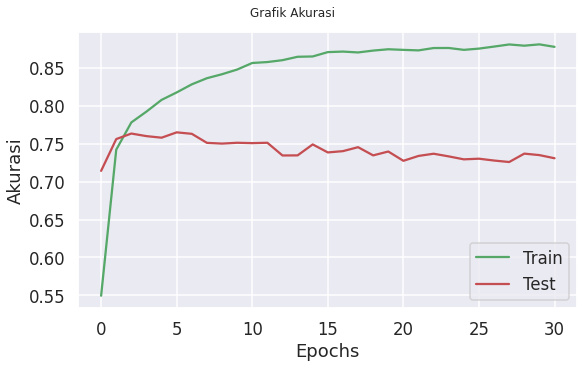

In [19]:
fig, ax = plt.subplots(figsize=(8, 5), constrained_layout=True)
fig.suptitle("Grafik Akurasi")
_ = plt.plot(hist.history["accuracy"], color="g", label="Train")
_ = plt.plot(hist.history["val_accuracy"], color="r", label="Test")
_ = ax.set_xlabel("Epochs")
_ = ax.set_ylabel("Akurasi")
_ = ax.legend()

plt.show()

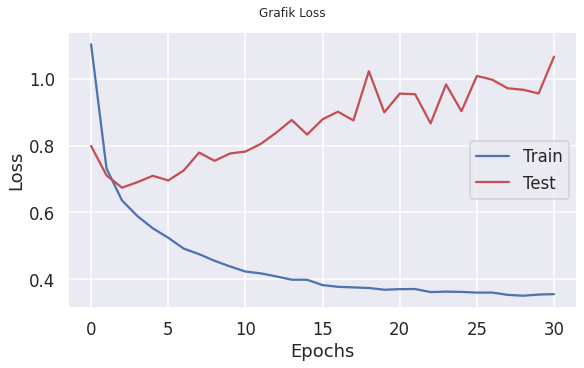

In [20]:
fig, ax = plt.subplots(figsize=(8, 5), constrained_layout=True)
fig.suptitle("Grafik Loss")
_ = plt.plot(hist.history["loss"], color="b", label="Train")
_ = plt.plot(hist.history["val_loss"], color="r", label="Test")
_ = ax.set_xlabel("Epochs")
_ = ax.set_ylabel("Loss")
_ = ax.legend()

plt.show()